## Imports

In [1]:
%matplotlib inline
from utils import *
from plotting import *
from models import *

## Load Dataset (e.g., Animal-AI_v3)

In [2]:
dataset, pose = load_dataset('dataset_animalai3', file_format='.npy', load_pose=True, pose_filename='pose.npy')

In [3]:
position = pose[:,:2]
orientation = pose[:,2]

In [4]:
print(dataset.shape, pose.shape)

(20000, 84, 84, 3) (20000, 3)


### Occupancy map

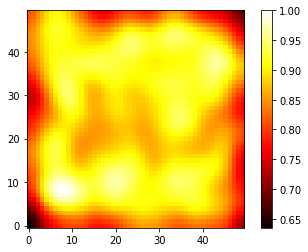

In [5]:
occ_map = occupancy_map(position, filter_width=3)
plt.imshow(occ_map, cmap='hot', origin='lower')
plt.colorbar()

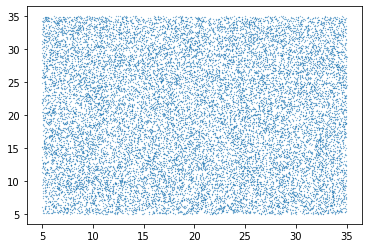

In [6]:
plt.scatter(position[:,0], position[:,1], s=.05)

## Hashing and clustering

In [7]:
from sklearn.cluster import OPTICS, KMeans

In [8]:
hashes = hashing_data(dataset)

In [9]:
print(hashes.shape)

(20000, 64)


In [10]:
hash_diffs, similarity_matrix = hamming_dist_matrix(hashes)

In [11]:
hash_diffs.shape

(20000, 20000)

In [17]:
hash_diffs_thres = np.copy(hash_diffs)
thres = 5
hash_diffs_thres[hash_diffs < thres] = 0
hash_diffs_thres[hash_diffs > thres] = 1

In [18]:
clustering = OPTICS(min_samples=5, metric='precomputed').fit(hash_diffs_thres) #leaf_size=30

C:\Users\adria\miniconda3\lib\site-packages\sklearn\cluster\_optics.py:932: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


In [12]:
clustering = OPTICS(min_samples=5, metric='hamming').fit(hashes) #leaf_size=30

In [19]:
cluster_labels = clustering.labels_
cluster_labels_onehot = np.zeros((cluster_labels.size, cluster_labels.max() + 1))
cluster_labels_onehot[np.arange(cluster_labels.size), cluster_labels] = 1
embeddings = cluster_labels_onehot

In [13]:
np.save('embeddings_20K.npy', embeddings)

In [10]:
embeddings = np.load('embeddings_20K.npy')

In [42]:
print( 'Number of clusters: ' + str(np.unique(cluster_labels).size) )

Number of clusters: 55


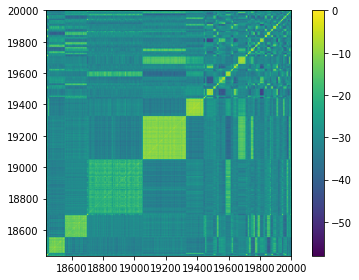

In [20]:
plot_similarity_matrix_clustered(similarity_matrix, cluster_labels, save=True)

## Rate maps of hashing 'buckets'

In [23]:
all_ratemaps = ratemaps(embeddings, position, n_bins=50, filter_width=3, occupancy_map=occ_map)

In [24]:
all_ratemaps = all_ratemaps[:-1]   # discarding the last one with the outliers (indx -1 in cluster_labels)

In [25]:
plot_ratemaps(all_ratemaps, save=True)

IndexError: index 53 is out of bounds for axis 0 with size 53

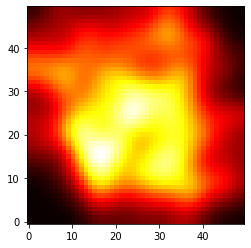

In [26]:
plt.imshow(np.sum(all_ratemaps, axis=0), cmap='hot', origin='lower')

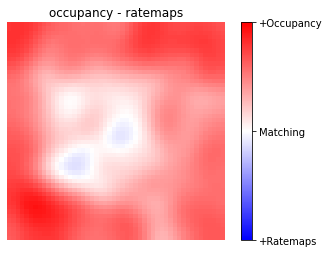

In [27]:
overall_ratemap = np.sum(all_ratemaps, axis=0).T
overall_ratemap = overall_ratemap/overall_ratemap.max()
map_diffs = occ_map - overall_ratemap
#min_ = np.min([map_diffs.min(), -map_diffs.max()])
#max_ = np.max([map_diffs.max(), -map_diffs.min()])
plt.imshow(map_diffs, cmap='bwr', origin='lower', vmin=-1, vmax=1)
plt.title('occupancy - ratemaps')
plt.axis('off')
cbar = plt.colorbar(ticks=[-1,0,1])
cbar.ax.set_yticklabels(['+Ratemaps', 'Matching', '+Occupancy']) 
plt.show()

In [50]:
degree_of_matching = np.round( np.sum(np.power(map_diffs, 2)) / np.count_nonzero(occ_map), 3)
print('MSE: ' + str(degree_of_matching))

MSE: 0.037


## Place field distribution

In [28]:
n_fields, centroids, sizes = stats_place_fields(all_ratemaps)

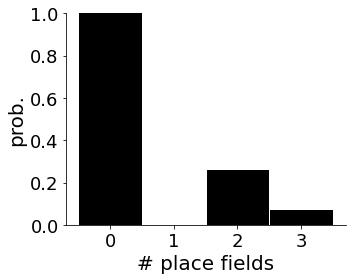

In [29]:
plot_place_field_hist(n_fields, save=True)

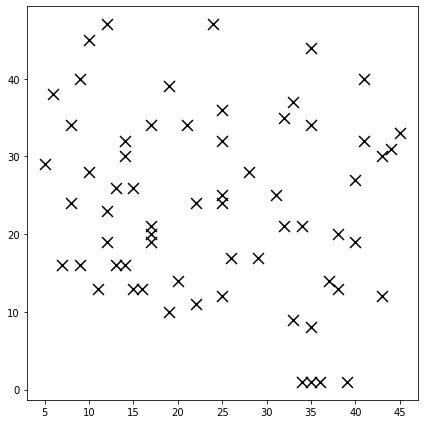

In [30]:
plt.figure(figsize=(6,6))

#plt.imshow(np.sum(all_ratemaps[:-1], axis=0), cmap='hot', origin='lower')
plt.scatter(centroids[:,0], centroids[:,1], color='black', marker='x', s=120)
#plt.axis('off')

plt.tight_layout()
plt.show()

In [31]:
print('Tiling homogeneity: ' + str(homogeneity_2Dtiling(centroids)))

Tiling homogeneity: 0.9338550835028026


## Spatial information

In [32]:
SI = spatial_information(all_ratemaps, occ_map)

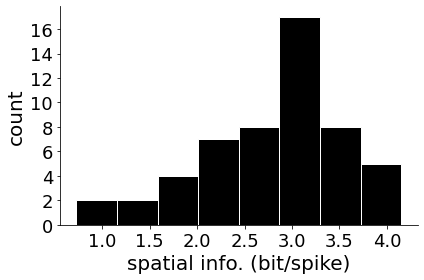

In [33]:
plt.hist(SI, color='black', bins=8, edgecolor='white')
plt.xlabel('spatial info. (bit/spike)', fontsize=20)
plt.ylabel('count', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
sb.despine()
plt.tight_layout()
plt.savefig('plot_spatial_info.jpg', dpi=600)
plt.show()

## Check whether centric place fields are also larger, i.e., if place fields close to the wall are smaller (and also more numerous) --> https://www.sciencedirect.com/science/article/pii/S0960982222010089 

In [34]:
dists_to_wall = dist_to_walls(centroids, occ_map)

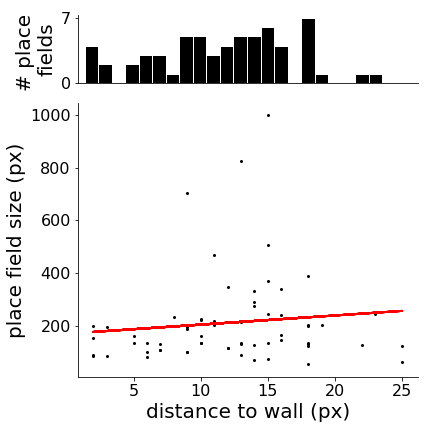

In [35]:
plot_distance_to_wall(dists_to_wall, sizes, save=True)

## Check hyperbolic geometry, i.e., exponential distribution of field sizes, as in: https://www.nature.com/articles/s41593-022-01212-4 

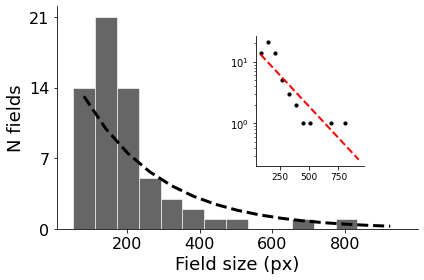

In [41]:
plot_hyperbolic_geometry(sizes, bin_width=60, save=True)

## Linear decoding of position

In [46]:
lin_score, baseline_score = linear_decoding_score(embeddings, position, n_baseline=100)

In [47]:
print('Linear decoder score: ' + str(lin_score))
print('Baseline avg.: ' + str(baseline_score[0]))

Linear decoder score: 0.10558883616818687
Baseline avg.: 0.013127870983292454


## Correlation between image distance, latent vector distance, and position

In [50]:
from scipy.stats import spearmanr

In [49]:
n_exp = 100000

spatial_pos_dist = []
latent_vec_dist = []
img_dist = []
for i in range(n_exp):
    ind_1, ind_2 = np.random.choice(np.arange(dataset.shape[0]), 2, replace=False)
    spatial_pos_dist.append( euclidean_distance(position[ind_1], position[ind_2]) )
    latent_vec_dist.append( np.sum(np.abs(hashes[ind_1] - hashes[ind_2])) )
    img_dist.append( euclidean_distance(dataset[ind_1], dataset[ind_2]) )

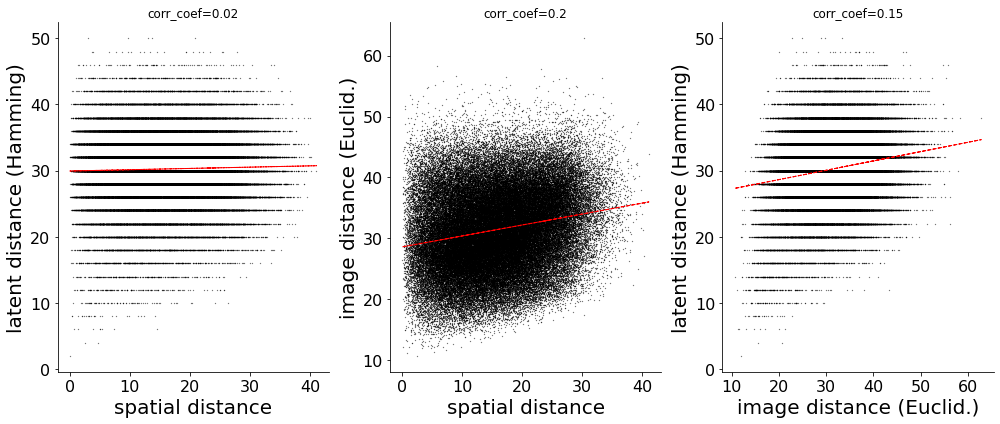

In [54]:
plt.figure(figsize=(14,6))

plt.subplot(131)
plt.scatter(spatial_pos_dist, latent_vec_dist, s=.05, color='black')
m,b = np.polyfit(spatial_pos_dist, latent_vec_dist, 1)
plt.plot(spatial_pos_dist, m*np.array(spatial_pos_dist)+b, linestyle='--', color='r', linewidth=1)
#plt.title('corr_coef='+str(np.corrcoef( spatial_pos_dist, latent_vec_dist )[0][1].round(2)))
plt.title('corr_coef='+str(spearmanr( spatial_pos_dist, latent_vec_dist ).correlation.round(2)))
plt.ylabel('latent distance (Hamming)', fontsize=20)
plt.xlabel('spatial distance', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
sb.despine()

plt.subplot(132)
plt.scatter(spatial_pos_dist, img_dist, s=.05, color='black')
m,b = np.polyfit(spatial_pos_dist, img_dist, 1)
plt.plot(spatial_pos_dist, m*np.array(spatial_pos_dist)+b, linestyle='--', color='r', linewidth=1)
#plt.title('corr_coef='+str(np.corrcoef( spatial_pos_dist, latent_vec_dist )[0][1].round(2)))
plt.title('corr_coef='+str(spearmanr( spatial_pos_dist, img_dist ).correlation.round(2)))
plt.ylabel('image distance (Euclid.)', fontsize=20)
plt.xlabel('spatial distance', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
sb.despine()

plt.subplot(133)
plt.scatter(img_dist, latent_vec_dist, s=.05, color='black')
m,b = np.polyfit(img_dist, latent_vec_dist, 1)
plt.plot(img_dist, m*np.array(img_dist)+b, linestyle='--', color='r', linewidth=1)
#plt.title('corr_coef='+str(np.corrcoef( spatial_pos_dist, latent_vec_dist )[0][1].round(2)))
plt.title('corr_coef='+str(spearmanr( img_dist, latent_vec_dist ).correlation.round(2)))
plt.ylabel('latent distance (Hamming)', fontsize=20)
plt.xlabel('image distance (Euclid.)', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
sb.despine()

plt.tight_layout()
plt.show()

## Head direction cells

In [38]:
all_polarmaps = polarmaps(embeddings, orientation)

In [39]:
plot_polarmaps(all_polarmaps, n_cells_plot=30)

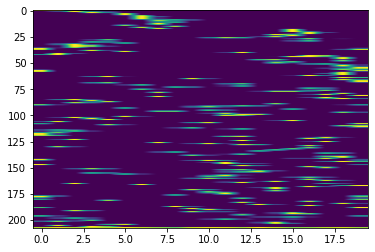

In [40]:
plt.imshow(all_polarmaps, aspect='auto', interpolation=None)

## Single unit contribution (ablation exp.)

In [ ]:
single_cell_lin_scores = []
for i in range(embeddings.shape[1]):
    ablated_embed = np.delete(embeddings, i, axis=1)
    score, _ = linear_decoding_score(ablated_embed, position, n_baseline=1)
    single_cell_lin_scores.append(score)
score_full, _ = linear_decoding_score(embeddings, position, n_baseline=1)
single_cell_contribs = score_full - np.array(single_cell_lin_scores)

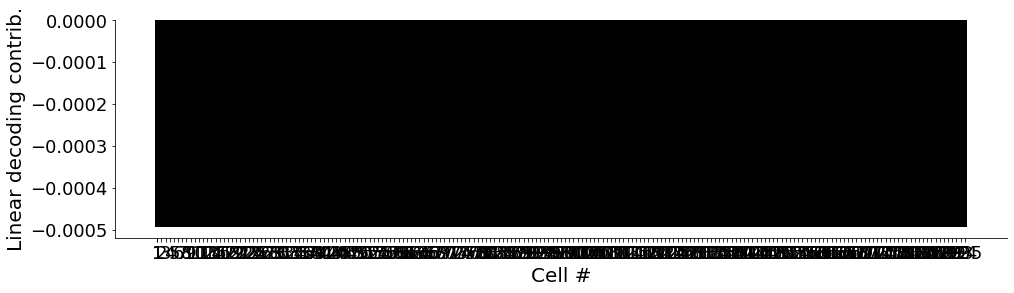

In [57]:
plt.figure(figsize=(16,4))
n_active = embeddings.shape[1]
plt.bar(np.arange(1, n_active+1), single_cell_contribs, color='black', alpha=1, width=1)
plt.xlabel('Cell #', fontsize=20)
plt.ylabel('Linear decoding contrib.', fontsize=20)
plt.yticks(fontsize=18)
plt.xticks(np.linspace(1, n_active, n_active+1, dtype=int), np.linspace(1, n_active, n_active+1, dtype=int), fontsize=18)
#plt.ylim(0,1)
sb.despine()
plt.show()

## Population coding (ablation exp.)

In [ ]:
n_exp = 10
pop_lin_scores = np.zeros((embeddings.shape[1], n_exp))
for i in range(embeddings.shape[1]):
    print(i)
    for j in range(n_exp):
        exclude = np.random.choice(np.arange(n_active), i, replace=False) 
        ablated_embed = np.delete(embeddings, exclude, axis=1)
        score, _ = linear_decoding_score(ablated_embed, position, n_baseline=1)
        pop_lin_scores[i,j] = score

In [124]:
mean_pop_lin_scores = np.mean(pop_lin_scores, axis=1)
std_pop_lin_scores = np.std(pop_lin_scores, axis=1)

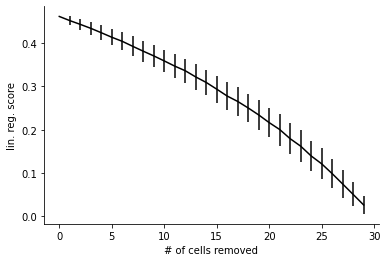

In [125]:
plt.errorbar(np.arange(n_active), mean_pop_lin_scores, yerr=std_pop_lin_scores, color='black')
plt.ylabel('lin. reg. score')
plt.xlabel('# of cells removed')
sb.despine()
plt.show()

## Control condition: shuffled hashes (permutation test)

In [27]:
hashes_shuffled = shuffle_2D_matrix(np.copy(hashes))

In [28]:
clustering_shuffled = OPTICS(min_samples=5, metric='hamming').fit(hashes_shuffled)

In [29]:
cluster_labels_shuffled = clustering_shuffled.labels_
np.unique(cluster_labels_shuffled).size

214

In [30]:
cluster_labels_onehot_shuffled = np.zeros((cluster_labels_shuffled.size, cluster_labels_shuffled.max() + 1))
cluster_labels_onehot_shuffled[np.arange(cluster_labels_shuffled.size), cluster_labels_shuffled] = 1

In [31]:
ratemaps_hashing_shuffled = ratemaps(cluster_labels_onehot_shuffled, position, n_bins=50, filter_width=3)

In [36]:
plot_ratemaps(ratemaps_hashing_shuffled, save=True)

In [33]:
n_fields_shuffled, centroids_shuffled, sizes_shuffled = stats_place_fields(ratemaps_hashing_shuffled)

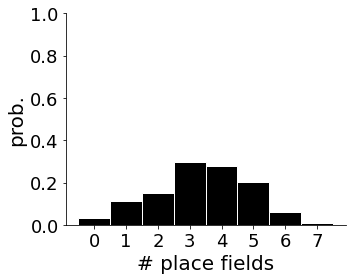

In [37]:
plot_place_field_hist(n_fields_shuffled, save=True)